In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from utils import Lottery, plot_values, plot_action_probs


torch.manual_seed(12046)

In [2]:
def get_cum_rewards(r, gamma):
    '''
    计算每一步的游戏得分并返回
    '''
    cum_rewards = []
    last_cum_reward = 0
    for j in reversed(r):
        last_cum_reward = j + gamma * last_cum_reward
        cum_rewards.insert(0, last_cum_reward)
    return cum_rewards

get_cum_rewards(torch.normal(1, 0.01, (10,)), 1)

[tensor(10.0095),
 tensor(9.0089),
 tensor(8.0156),
 tensor(7.0169),
 tensor(6.0171),
 tensor(4.9980),
 tensor(4.0106),
 tensor(3.0101),
 tensor(2.0078),
 tensor(0.9982)]

In [3]:
# 一些超参数
gamma = 0.9
learning_rate = 0.01
grad_clip = 1.0

In [4]:
class PolicyNet(nn.Module):
    
    def __init__(self):
        '''
        策略学习
        '''
        super().__init__()
        self.emb = nn.Embedding(2, 4)
        self.ln = nn.Linear(4, 2)

    def forward(self, x):
        '''
        向前传播
        参数
        ----
        x ：torch.LongTensor，游戏状态，形状为(G)，其中G表示游戏步数
        返回
        ----
        out ：torch.FloatTensor，logits，形状为(G, 2)
        '''
        x = F.relu(self.emb(x))
        out = self.ln(x)
        return out

# 定义游戏状态的数字表示
tokenizer = {'w': 0, 'l': 1}

In [5]:
@torch.no_grad()
def play_game(model, game):
    s = game.reset()
    done = False
    one_game_state = []
    one_game_reward = []
    one_game_action = []
    while not done:
        x = torch.tensor([tokenizer[s]])   # (1)
        logits = model(x)                  # (1, 2)
        probs = F.softmax(logits, dim=-1)  # (1, 2)
        # 利用神经网络得到下一个行动
        action = torch.multinomial(probs, 1)
        next_s, r = game.step(action)
        # 记录游戏过程，分别是行动、状态和奖励
        one_game_action.append(action)
        one_game_state.append(s)
        one_game_reward.append(r)
        s = next_s
        if next_s == 't':
            done = True
    return one_game_state, one_game_action, one_game_reward

In [6]:
model = PolicyNet()
game = Lottery()
play_game(model, game)

(['l'], [tensor([[0]])], [0])

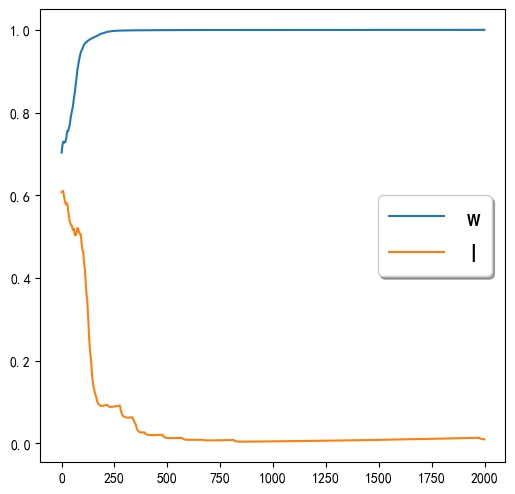

In [7]:
# Reinforce
model = PolicyNet()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
v = []

for t in range(2000):
    states, actions, rewards = play_game(model, game)
    # 将一次游玩看成是G次游玩
    cum_rewards = get_cum_rewards(rewards, gamma)
    cum_rewards = torch.tensor(cum_rewards)                    # (G)
    actions = torch.concat(actions).squeeze(-1)                # (G)
    states = torch.tensor([tokenizer[s] for s in states])      # (G)
    optimizer.zero_grad()
    logits = model(states)                                     # (G, 2)
    lnP = -F.cross_entropy(logits, actions, reduction='none')  # (G)
    # 定义模型损失
    loss = -cum_rewards * lnP                                  # (G)
    loss.mean().backward()
    optimizer.step()
    # 记录每个状态下，模型预估的每个行动的概率
    eval_re = {}
    for k in tokenizer:
        _re = F.softmax(model(torch.tensor([tokenizer[k]])), dim=-1)  # (1, 2)
        eval_re[k] = _re.squeeze(0).tolist()
    v.append(eval_re)
    
fig = plot_action_probs(v)
fig.savefig('policy_learning.png', dpi=200)